In [1]:
from PIL import Image
from matplotlib import image
from matplotlib import pyplot
from glob import glob
import os
import numpy as np
import torch
import h5py
from models.model import ResNet18Model
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation
import torchvision.transforms.functional as F
import random
from torchvision import models

/home/somahansel/anaconda3/envs/mnist_test/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
def mergeParams(model1, model2, model3, model4, model5):
    dict1 = model1.state_dict()
    dict2 = model2.state_dict()
    dict3 = model3.state_dict()
    dict4 = model4.state_dict()
    dict5 = model5.state_dict()
    dict_avg = {}

    for name, _ in model1.named_parameters():
        dict_avg[name] = (dict1[name] + dict2[name] + dict3[name] + dict4[name] + dict5[name]) / 5

    model1.load_state_dict(dict_avg, strict=False)
    model2.load_state_dict(dict_avg, strict=False)
    model3.load_state_dict(dict_avg, strict=False)
    model4.load_state_dict(dict_avg, strict=False)
    model5.load_state_dict(dict_avg, strict=False)

In [2]:
from site_training import MultiSiteTrainingApp
model1 = ResNet18Model(num_classes=200)
model2 = ResNet18Model(num_classes=200)
model3 = ResNet18Model(num_classes=200)
model4 = ResNet18Model(num_classes=200)
model5 = ResNet18Model(num_classes=200)
name = 'model.conv1.weight'
dict1 = {name: torch.zeros((64, 3, 7, 7))}
dict2 = {name: torch.zeros((64, 3, 7, 7)) + 1}
dict3 = {name: torch.zeros((64, 3, 7, 7)) + 2}
dict4 = {name: torch.zeros((64, 3, 7, 7)) + 4}
dict5 = {name: torch.zeros((64, 3, 7, 7)) + 4}

In [3]:
model1

ResNet18Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
model1.load_state_dict(dict1, strict=False)
model2.load_state_dict(dict2, strict=False)
model3.load_state_dict(dict3, strict=False)
model4.load_state_dict(dict4, strict=False)
model5.load_state_dict(dict5, strict=False)

In [27]:
mergeParams(model1, model2, model3, model4, model5)

In [ ]:
for name, _ in model1.named_parameters():
    print(name)

In [ ]:
model = models.resnet18(weights=None)
model.fc = torch.nn.Linear(512, 200)
state_dict_path = '/home/somahansel/work/imagenettest/saved_models/site1/imagenet_2023-02-07_03.20.48_lr5.best.state'
model.load_state_dict(torch.load(state_dict_path), strict=False)

In [32]:
f = h5py.File('data/tiny_imagenet_trn.hdf5', 'r')
data = f['data']
image = np.asarray(data[9])
image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(dim=0)
print(torch.argmax(model(image)))

tensor(100)


In [10]:
param_num = 0
for name, param in model1.named_parameters():
    if name.split('.')[1] == 'layer4':
        param_num += param.numel()
print('Initiated model with {} params'.format(param_num))

Initiated model with 11279112 params


In [34]:
train_data_path = 'data/train'
val_data_path = 'data/val/images'
test_data_path = 'data/test/images'

train_path_list = glob(os.path.join(train_data_path, '*', 'images', '*'))
train_path_list.sort()
val_path_list = glob(os.path.join(val_data_path, '*'))
val_path_list.sort()
tst_path_list = glob(os.path.join(test_data_path, '*'))
tst_path_list.sort()

In [35]:
trn_lables = [os.path.split(path)[-1][:9] for path in train_path_list]
print(trn_lables[500])

n01629819


In [36]:
with open('data/val/val_annotations.txt') as f:
    lines = f.readlines()
    val_tuples = [line.split("\t")[:2] for line in lines]

In [ ]:
trn_images = np.zeros((100000, 64, 64, 3), dtype=np.float32)
val_images = np.zeros((10000, 64, 64, 3), dtype=np.float32)
tst_images = np.zeros((10000, 64, 64, 3), dtype=np.float32)

for i, path in enumerate(train_path_list):
    image = Image.open(path)
    data = np.asarray(image)
    if len(data.shape) == 2:
        data = np.stack([data, data, data], axis=2)
    trn_images[i] = data

for i, tuple in enumerate(val_tuples):
    path = os.path.join(val_data_path, tuple[0])
    image = Image.open(path)
    data = np.asarray(image)
    if len(data.shape) == 2:
        data = np.stack([data, data, data], axis=2)
    val_images[i] = data

for i, path in enumerate(tst_path_list):
    image = Image.open(path)
    data = np.asarray(image)
    if len(data.shape) == 2:
        data = np.stack([data, data, data], axis=2)
    tst_images[i] = data

In [ ]:
trn_mean = np.mean(trn_images, axis=(0, 1, 2))
trn_std = np.std(trn_images, axis=(0, 1, 2))

val_mean = np.mean(val_images, axis=(0, 1, 2))
val_std = np.std(val_images, axis=(0, 1, 2))

tst_mean = np.mean(tst_images, axis=(0, 1, 2))
tst_std = np.std(tst_images, axis=(0, 1, 2))

In [ ]:
image = Image.open('data/train/n01629819/images/n01629819_0.JPEG')
np_data = np.asarray(image)
print(np_data.shape)
print(image.format)
print(image.size)
print(image.mode)
pyplot.imshow(image)
pyplot.show()

In [ ]:
image = trn_images[500]
print(image.dtype)
pyplot.imshow(image.astype(int))
pyplot.show()

2023-02-06 17:29:34,488 WARNING  pid:93053 matplotlib.image:725:set_data Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


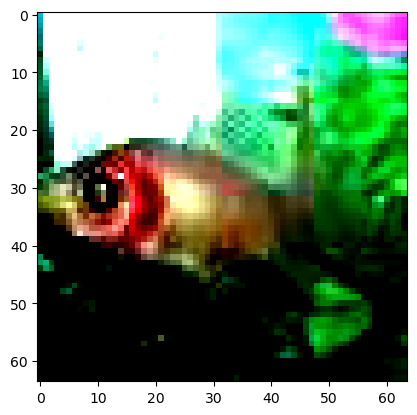

In [112]:
angles = [0, 90, 180, 270]
angle = random.choice(angles)
flip = random.choice([True, False])
print(angle)
f = h5py.File('data/tiny_imagenet_trn.hdf5', 'r')
data = f['data']
labels = f['labels']
image = np.asarray(data[0])
image = torch.from_numpy(image).permute(2, 0, 1)
if flip:
    image = F.hflip(image)
image = F.rotate(image, angle).permute(1, 2, 0)
image = np.asarray(image)
label = labels[500]
pyplot.imshow(image.astype(float))
pyplot.show()

In [ ]:
f = h5py.File('data/tiny_imagenet_val.hdf5', 'r')
labels = f['labels']
strings = labels.asstr()[()]
label = strings[500]
print(label)

In [3]:
model = ResNet18Model(num_classes=200)
f = h5py.File('data/tiny_imagenet_trn.hdf5', 'r')
data = f['data']
labels = f['labels']
image = np.asarray(data[500])
image = torch.from_numpy(image)
image = image.permute(2, 0, 1).unsqueeze(dim=0)
label = labels[500]
out = model(image)
print(out[0,10])

tensor(0.2880, grad_fn=<SelectBackward0>)


In [ ]:
for name, param in model.named_parameters():
    print(name, param.shape)

In [ ]:
model1 = ResNet18Model(num_classes=200)
dict = model1.state_dict()
print(dict)

In [115]:
l = []
for _ in range(10):
    l.append([])
print(l)

[[], [], [], [], [], [], [], [], [], []]
